In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
# InteractiveShell.ast_node_interactivity = "last"

In [2]:
import os
import numpy as np
import logging
import faiss
from vasili_helpers import *

In [3]:
def load_dataset(dataset_path: str):
    """
    Load the dataset from the specified path.

    Args:
        dataset_path (str): Path to the directory containing the dataset files.

    Returns:
        Dict[str, np.ndarray]: A dictionary with keys:
            - 'xb': The database vectors.
            - 'xq': The query vectors (if available).
            - 'gt': The ground truth nearest neighbors (if available).
    """
    logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s: %(message)s')
    logger = logging.getLogger(__name__)

    if not os.path.exists(dataset_path):
        raise FileNotFoundError(f"Dataset path {dataset_path} does not exist.")

    dataset_files = os.listdir(dataset_path)
    logger.info(f"Found files in dataset path: {dataset_files}")

    # Initialize placeholders for dataset components
    xb = None
    xq = None
    gt = None

    # Identify files for xb, xq, and gt
    for file in dataset_files:
        file_path = os.path.join(dataset_path, file)

        if file.startswith("xb"):
            if "queries" not in file and "ground_truth" not in file:
                xb = np.load(file_path, allow_pickle=True)  # Enable pickle loading
                logger.info(f"Loaded database vectors (xb) from: {file}")
        elif file.startswith("xq"):
            xq = np.load(file_path, allow_pickle=True)  # Enable pickle loading
            logger.info(f"Loaded query vectors (xq) from: {file}")
        elif file.startswith("gt"):
            gt = np.load(file_path, allow_pickle=True)  # Enable pickle loading
            logger.info(f"Loaded ground truth indices (gt) from: {file}")

    if xb is None:
        raise ValueError(f"Database vectors (xb) could not be found in {dataset_path}.")

    dataset = {'xb': xb}
    if xq is not None:
        dataset['xq'] = xq
    if gt is not None:
        dataset['gt'] = gt

    logger.info("Dataset successfully loaded.")
    return dataset


In [ ]:
# _workload = "dataset_sift1m-clusters_1000-csf_0.1000-clusterSample_15.00"
workload_name = "dataset_sift1m-clusters_1000-csf_1.0000-clusterSample_1.00"

dataset_path = f"/local/home/vmageirakos/projects/crack-vdb/workload_output/{workload_name}"
data = load_dataset(dataset_path)

xb = data['xb']
xq = data.get('xq', None)  # xq and gt are optional
gt = data.get('gt', None)

print(f"Loaded database vectors shape: {xb.shape}")
if xq is not None:
    print(f"Loaded query vectors shape: {xq.shape}")
if gt is not None:
    print(f"Loaded ground truth indices shape: {gt.shape}")

2024-12-05 16:38:14,456 - INFO: Found files in dataset path: ['run_metadata.json', 'cluster_centroids-clusters_1000-csf_1.0000-.npy', 'xq-clusters_1000-csf_1.0000-.npy', 'xb-sift1m.npy', 'query_metadata-nqueries_10000-knn_100-clusterSample_1.0-', 'gt-clusters_1000-csf_1.0000-.npy', 'cluster_labels-clusters_1000-csf_1.0000-.npy']
2024-12-05 16:38:14,457 - INFO: Loaded query vectors (xq) from: xq-clusters_1000-csf_1.0000-.npy
2024-12-05 16:38:14,547 - INFO: Loaded database vectors (xb) from: xb-sift1m.npy
2024-12-05 16:38:14,548 - INFO: Loaded ground truth indices (gt) from: gt-clusters_1000-csf_1.0000-.npy
2024-12-05 16:38:14,548 - INFO: Dataset successfully loaded.


Loaded database vectors shape: (1000000, 128)
Loaded query vectors shape: (94, 128)
Loaded ground truth indices shape: (94, 100)


In [6]:
xb.shape
xq.shape
gt.shape

(1000000, 128)

(94, 128)

(94, 100)

In [7]:
def compute_recalls(IDX, GRND_TRTH, k_values=[1, 10, 50, 100]):
    """
    Compute recall@k for multiple k values.
    
    Args:
        IDX: numpy array of shape (N, max_k) containing retrieved indices
        GRND_TRTH: numpy array of shape (N, max_k) containing ground truth indices
        k_values: list of k values to compute recall for
    
    Returns:
        dict: Dictionary mapping k values to their corresponding recall scores
    """
    # Input validation
    assert IDX.shape == GRND_TRTH.shape, f"Shape mismatch: IDX {IDX.shape} vs GRND_TRTH {GRND_TRTH.shape}"
    max_k=max(k_values)
    assert IDX.shape[1] >= max_k, f"IDX must have at least 100 columns, got {IDX.shape[1]}"
    
    N = IDX.shape[0]  # number of queries
    recalls = {}
    
    for k in k_values:
        total_hits = 0
        for i in range(N):
            # Get relevant items from ground truth and retrieved items
            gt_set = set(GRND_TRTH[i, :k])
            retrieved_set = set(IDX[i, :k])
            
            # Compute intersection
            hits = len(gt_set & retrieved_set)
            total_hits += hits
        
        # Compute recall@k
        # Note: we divide by (N * k) because each query should have k relevant items
        recalls[k] = total_hits / (N * k)
    
    return recalls

In [8]:

def compute_recall(IDX, GRND_TRTH, k):
    """
    shapes shoudl be (N, dim) N: num points, dim: dimensions fo vectors
    """
    recall = 0
    for i in range(IDX.shape[0]):
        # Compare top-k indices with ground truth
        relevant = GRND_TRTH[i][:k]  # Get relevant items from ground truth
        retrieved = IDX[i][:k]  # Get top-k retrieved items
        # Check how many relevant items are in the retrieved items
        recall += len(set(retrieved) & set(relevant))
    
    return recall / (IDX.shape[0] * k)


In [9]:
nb, d = xb.shape

In [10]:
k=100

# FAISS index creation
nlist = 1000  # number of clusters for IVF
quantizer = faiss.IndexFlatL2(d)  # flat index for coarse quantization
index_ivf_small = faiss.IndexIVFFlat(quantizer, d, nlist, faiss.METRIC_L2)

# Train the IVF index
index_ivf_small.train(xb)
index_ivf_small.add(xb)

In [11]:
%%time
# Search
index_ivf_small.nprobe = 20  # number of clusters to search
distances, indices = index_ivf_small.search(xq, k)  # perform search

# Compute Recall@k
recall_at_k = compute_recall(indices, gt, k)
print(f"Recall@{k}: {recall_at_k:.4f}")

Recall@100: 0.9303
CPU times: user 1.79 s, sys: 84.8 ms, total: 1.88 s
Wall time: 15 ms


In [ ]:
k=100

# FAISS index creation
nlist = 10000  # number of clusters for IVF
quantizer = faiss.IndexFlatL2(d)  # flat index for coarse quantization
index_ivf = faiss.IndexIVFFlat(quantizer, d, nlist, faiss.METRIC_L2)

# Train the IVF index
index_ivf.train(xb)
index_ivf.add(xb)

Recall@100: 0.4365


In [ ]:
%%time
# Search
index_ivf.nprobe = 70  # number of clusters to search
distances, indices = index_ivf.search(xq, k)  # perform search

# Compute Recall@k
recall_at_k = compute_recall(indices, gt, k)
print(f"Recall@{k}: {recall_at_k:.4f}")

Recall@100: 0.9160
CPU times: user 2.66 s, sys: 5.38 s, total: 8.04 s
Wall time: 67.5 ms


In [43]:
from vasili_helpers import *

In [44]:
xq

array([[23.,  3.,  7., ..., 25., 51., 22.],
       [76.,  8.,  1., ...,  2.,  7., 18.],
       [62.,  0.,  0., ..., 19.,  1.,  4.],
       ...,
       [43.,  1.,  0., ..., 11., 10.,  6.],
       [91.,  0.,  0., ...,  7., 11.,  3.],
       [58., 42., 21., ..., 52., 54.,  1.]], dtype=float32)

- Total number of unique centroids visited: 2788
- % of total centroids: 28.000000000000004 %


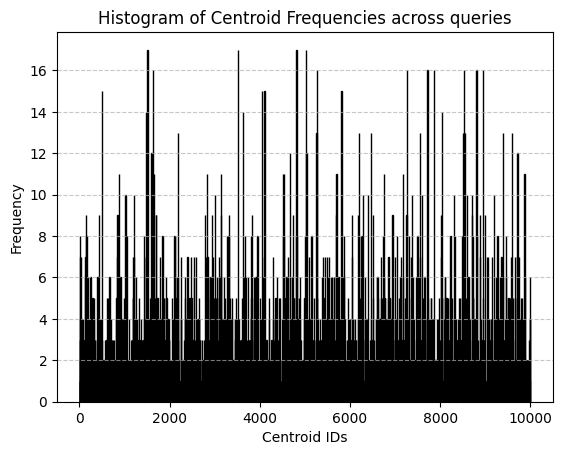

In [107]:
get_centroid_ids_per_query(
    index_ivf, 
    # index_ivf_small, 
    xq, 
    nprobe=70, 
    # nprobe=15, 
    plot_hist=True
    )

# tldr; RUN THIS

In [7]:
import os
import numpy as np
import logging
import faiss
from vasili_helpers import *
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
# InteractiveShell.ast_node_interactivity = "last"


In [2]:
xb, xq, xt, gt, metric = load_sift1M(f"/pub/scratch/vmageirakos/datasets/ann-fvecs/sift-128-euclidean")

Loading sift1M...

dataset shape:
xb.shape=(1000000, 128)
gt.shape=(10000, 100)
xq.shape=(10000, 128)


done


Training level-1 quantizer
Training level-1 quantizer on 1000000 vectors in 128D
Training IVF residual
IndexIVF: no residual training
IndexIVFFlat::add_core: added 1000000 / 1000000 vectors
Training level-1 quantizer
Training level-1 quantizer on 1000000 vectors in 128D
Training IVF residual
IndexIVF: no residual training
IndexIVFFlat::add_core: added 1000000 / 1000000 vectors


(1, 2)

(1576, 100)

visited_cids=array([  0,   4,   8,   9,  12,  18,  19,  21,  24,  27,  29,  30,  31,
        32,  33,  34,  37,  38,  42,  43,  45,  47,  52,  53,  54,  55,
        56,  59,  63,  70,  74,  76,  77,  79,  82,  83,  86,  87, 100,
       102, 104, 106, 107, 112, 114, 119, 123, 127, 129, 131, 133, 134,
       135, 137, 139, 140, 142, 143, 145, 146, 147, 148, 149, 150, 153,
       154, 155, 156, 161, 164, 170, 171, 175, 176, 179, 185, 186, 187,
       188, 191, 194, 196, 200, 201, 203, 205, 207, 209, 210, 216, 219,
       220, 223, 224, 228, 229, 230, 232, 234, 236, 238, 239, 240, 241,
       245, 246, 247, 252, 256, 264, 268, 269, 272, 274, 280, 286, 288,
       291, 293, 294, 295, 298, 304, 306, 312, 313, 316, 317, 321, 323,
       324, 333, 334, 335, 336, 337, 339, 347, 348, 350, 356, 360, 361,
       363, 364, 365, 367, 373, 375, 378, 386, 387, 388, 392, 398, 401,
       402, 406, 407, 408, 412, 417, 419, 420, 421, 425, 435, 436, 438,
       443, 447, 448, 450, 453, 456, 461, 462, 472,

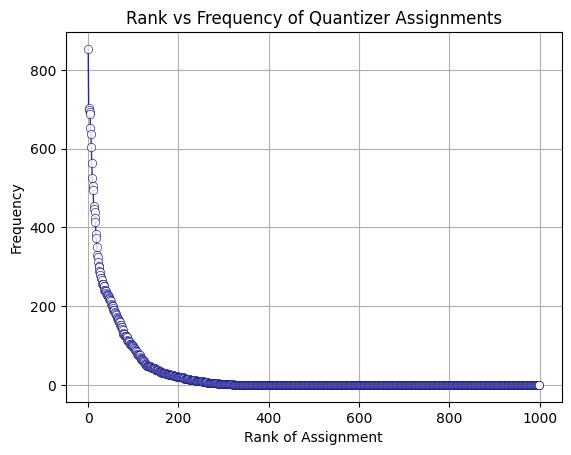

0.8001078680203045

0.7228997461928934

In [15]:
k=100
nlist = 1000 
nprobe = 20
d = xb.shape[1]
compute_GT = True
SEED = 42

### init trained index
# ndex for coarse quantization
trained_quantizer = faiss.IndexFlatL2(d)  # flat index for coarse quantization
trained_index = faiss.IndexIVFFlat(trained_quantizer, d, nlist, faiss.METRIC_L2)
trained_index.cp.seed = SEED
trained_index.cp.niter= 25
trained_index.cp.nredo = 1
trained_index.verbose=True
# Train the IVF index
trained_index.train(xb)
trained_index.add(xb)

### init untrained index
untrained_quantizer = faiss.IndexFlatL2(d)  # flat index for coarse quantization
untrained_index = faiss.IndexIVFFlat(untrained_quantizer, d, nlist, faiss.METRIC_L2)
untrained_index.cp.seed = SEED #int(time.time())
untrained_index.cp.niter= 0
untrained_index.verbose=True
untrained_index.train(xb)
untrained_index.add(xb)

# Chose vectors from nearby clusters ( ~SKEWED DATASET HERE <<<<<< ? )
centr_first_cluster = trained_index.quantizer.reconstruct_n()[0]
n_nearest_cents = 2 # number of nearby clusters, if 1 then they are all from same cluster
nearest_cents = trained_index.quantizer.assign(centr_first_cluster.reshape(1, -1), n_nearest_cents)
nearest_cents.shape
# ids, codes = get_invlist(trained_index.invlists, 10)
ids, codes = get_points_in_invlists(trained_index, nearest_cents.ravel())
selected_vectors = codes.view("float32")

#### compute ground truth
if compute_GT:
    # selected_vectors.shape
    k= 100
    gt_index = faiss.IndexFlatL2(d)
    gt_index.add(xb)
    D, gt_selected_vectors = gt_index.search(selected_vectors, k)
    gt_selected_vectors.shape


## plot skew
_ = get_centroid_ids_per_query(
    # index_ivf, 
    untrained_index, 
    selected_vectors, 
    nprobe=nprobe, 
    # nprobe=15, 
    plot_hist=True,
    sorted_order=True
    )

# recall target
trained_index.nprobe = nprobe
_, res_ids = trained_index.search(selected_vectors, k)
compute_recall(res_ids, gt_selected_vectors, k)



# recall target
untrained_index.nprobe = nprobe
_, res_ids_untrained = untrained_index.search(selected_vectors, k)
compute_recall(res_ids_untrained, gt_selected_vectors, k)

In [153]:
#### get recall
selected_vectors
trained_index.nprobe = nprobe
D, I_sel_vec_trained = trained_index.search(selected_vectors, k)

print("trained recall")
print(compute_recall(I_sel_vec_trained, gt_selected_vectors, k))

untrained_index.nprobe = nprobe
D, I_sel_vec = untrained_index.search(selected_vectors, k)
print("un-trained recall")
print(compute_recall(I_sel_vec, gt_selected_vectors, k))

array([[  5.,   1.,   1., ...,   1.,   1.,   3.],
       [ 49.,  44.,   1., ...,   0.,   0.,  33.],
       [ 39.,   3.,   5., ...,   6.,   0.,  13.],
       ...,
       [ 44.,  37.,   1., ...,   0.,   1.,   7.],
       [ 94.,   4.,   0., ...,   0.,   0.,  91.],
       [110.,   5.,   0., ...,   0.,   0.,  60.]], dtype=float32)

trained recall
0.8746306068601584
un-trained recall
0.7855277044854881


In [154]:
INDEX = trained_index

<Figure size 800x600 with 0 Axes>

Text(0.5, 0, 'Rank of Assignment')

Text(0, 0.5, 'Frequency (log scale)')

Text(0.5, 1.0, 'Zipfian Distribution of Quantizer Assignments (Log-Log Plot)')

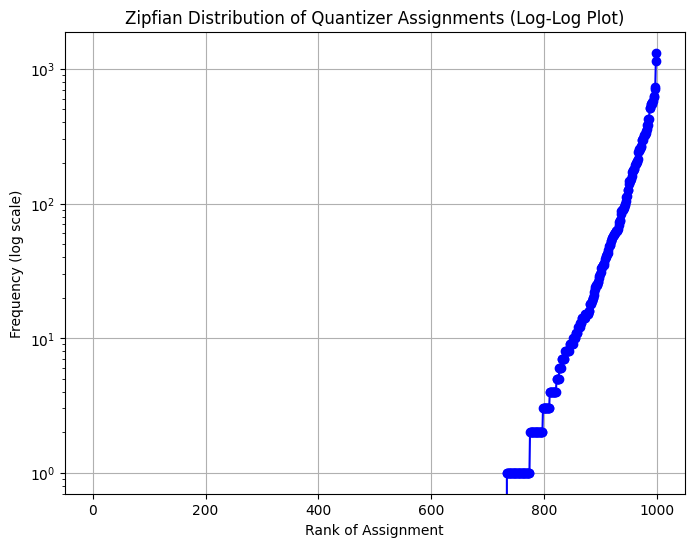

- Total number of unique centroids visited: 266
- % of total centroids: 27.0 %


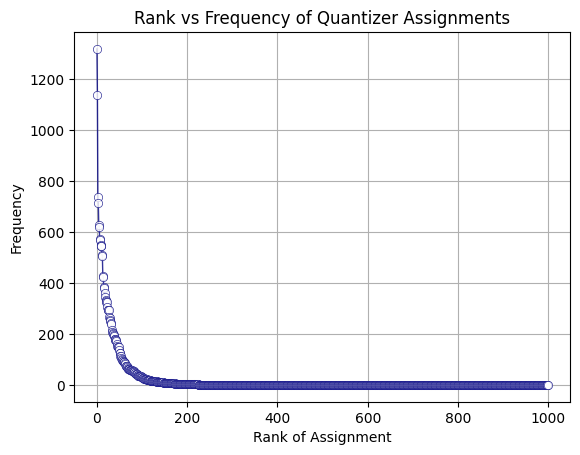

In [155]:
# Example of quantizer.assign(perturbed_vectors, nprobe) usage
# nprobe=20
assignment_counts = Counter(INDEX.quantizer.assign(selected_vectors, nprobe).ravel())

# Ensure all centroids are included, even if some are missing

for i in range(nlist):
    if i not in assignment_counts:
        assignment_counts[i] = 0

# Sort assignments by frequency (descending order)
sorted_assignments = sorted(assignment_counts.items(), key=lambda x: x[1], reverse=False)

# Extract the sorted assignments and counts
unique_assignments = [item[0] for item in sorted_assignments]
counts = [item[1] for item in sorted_assignments]

# Plotting the frequencies to visualize Zipfian distribution
plt.figure(figsize=(8, 6))
plt.plot(counts, marker='o', linestyle='-', color='b')

# Log-log scale
# plt.xscale('log')
plt.yscale('log')

plt.xlabel('Rank of Assignment')
plt.ylabel('Frequency (log scale)')
plt.title('Zipfian Distribution of Quantizer Assignments (Log-Log Plot)')
plt.grid(True)
plt.show()

get_centroid_ids_per_query(
    # index_ivf, 
    INDEX, 
    selected_vectors, 
    nprobe=nprobe, 
    # nprobe=15, 
    plot_hist=True,
    sorted_order=True
    )

What happens if we select from trained index and we run on a random other index, is the centroid distr skewed?

- Total number of unique centroids visited: 283
- % of total centroids: 28.000000000000004 %


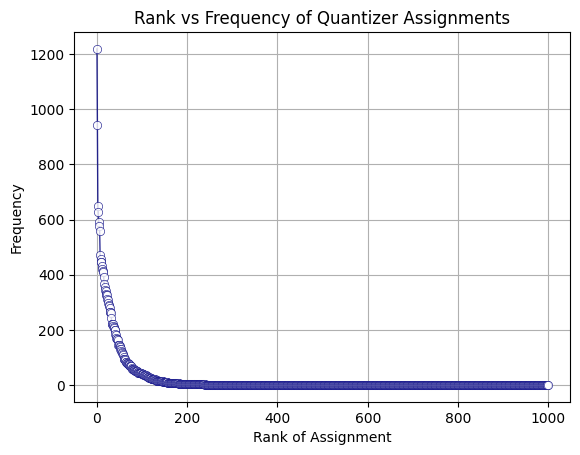

In [159]:
# k=100
# # FAISS index creation
# nlist = 1000  # number of clusters for IVF

other_quantizer = faiss.IndexFlatL2(d)  # flat index for coarse quantization
other_index = faiss.IndexIVFFlat(other_quantizer, d, nlist, faiss.METRIC_L2)
other_index.cp.seed = int(time.time())
other_index.cp.niter = 0

# Train the IVF index
other_index.train(xb)
other_index.add(xb)


get_centroid_ids_per_query(
    # index_ivf, 
    other_index, 
    selected_vectors, 
    nprobe=nprobe, 
    # nprobe=15, 
    plot_hist=True,
    sorted_order=True
    )

If not enough queries and you want more but same distribution. You can pertrube them a bit:


In [ ]:
import numpy as np

def generate_perturbed_vectors(input_vectors, epsilon, target_num_queries):
    """
    Generate perturbed vectors for randomly selected vectors from the input dataset until 
    the total number of vectors reaches target_num_queries.

    :param input_vectors: The input array of vectors (2D numpy array with shape (n, dimensions)).
    :param epsilon: The perturbation magnitude.
    :param target_num_queries: The target number of perturbed vectors to generate.
    :return: A numpy array of perturbed vectors with shape (target_num_queries, dimensions).
    """
    n_vectors, dimensions = input_vectors.shape

    if target_num_queries < n_vectors:
        raise ValueError("target_num_queries must be greater than or equal to the number of input vectors.")

    # Initialize an array to hold the perturbed vectors
    perturbed_vectors = []

    # Randomly select vectors and generate perturbations until the target is reached
    while len(perturbed_vectors) < target_num_queries:
        # Randomly sample vectors from the input dataset
        indices = np.random.choice(n_vectors, size=min(target_num_queries - len(perturbed_vectors), n_vectors), replace=False)
        sampled_vectors = input_vectors[indices]

        # Generate Gaussian perturbations for the sampled vectors
        perturbations = np.random.normal(loc=0, scale=epsilon, size=sampled_vectors.shape)
        perturbed_batch = sampled_vectors + perturbations

        # Append perturbed vectors to the list
        perturbed_vectors.extend(perturbed_batch)

    # Trim the array to the exact target_num_queries size
    perturbed_vectors = np.array(perturbed_vectors[:target_num_queries])

    return perturbed_vectors

(10000, 128)


Here's what I am notising:
- The smaller the dataset eg. sift1m, the less points in a single cluster (obviously) 
- The approximate %of total centroids touched by a single query even if you change indexes remains the same ( as long as nprobe is smalle)
- The more you increase nprobe the higher the variety of centroids 
- The more you increase nearest centroids added to selected poitns the higher the variety of centroids.

What I suggest:
- Pick a single cluster, get all points ~1k points for 1M/1k clusters
    - Assert that it is mostly power-law distributed even at "higher" nprobes.
- Then pertrube those poitns with ~5% of the vector data range and create ( synthetic queries, that follow the same distribution ) until you hit some target_num_queries
- You now have your skewed query set

(10000, 128)
- Total number of unique centroids visited: 337
- % of total centroids: 34.0 %


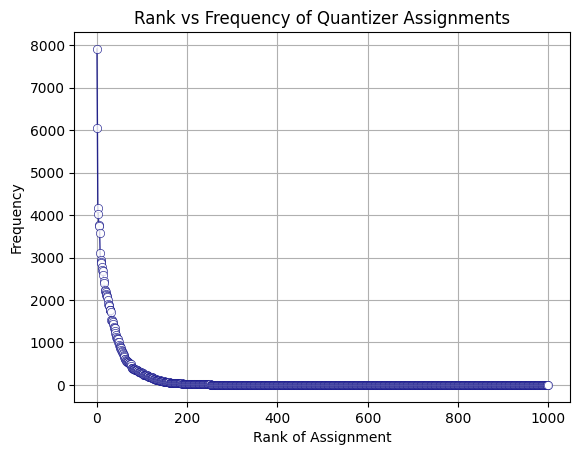

before:
- Total number of unique centroids visited: 283
- % of total centroids: 28.000000000000004 %


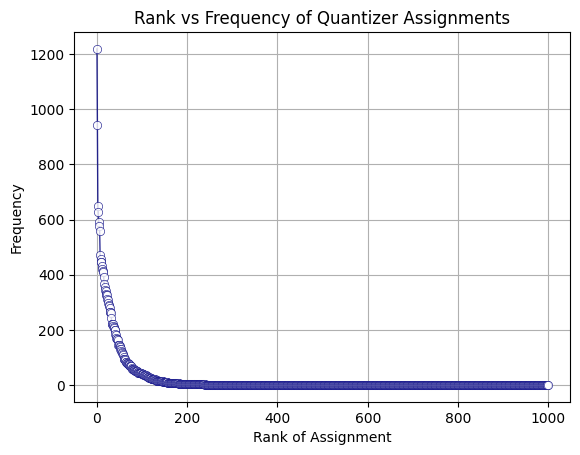

In [205]:

# Example Usage
vector_range = np.max(xb) - np.min(xb)
epsilon = 0.05 * vector_range  # x% of the data range <<<< some way to set epsilon that is intuitive

# epsilon = 2  # Perturbation magnitude
target_num_queries = 10000  # Target number of perturbed vectors

selected_perturbed_vectors = generate_perturbed_vectors(selected_vectors, epsilon, target_num_queries)
print(selected_perturbed_vectors.shape)  # Should be (10000, d)

get_centroid_ids_per_query(
    # index_ivf, 
    other_index, 
    selected_perturbed_vectors, 
    nprobe=nprobe, 
    # nprobe=15, 
    plot_hist=True,
    sorted_order=True
    )
    
print("before:")

get_centroid_ids_per_query(
    # index_ivf, 
    other_index, 
    selected_vectors, 
    nprobe=nprobe, 
    # nprobe=15, 
    plot_hist=True,
    sorted_order=True
    )

If you want "extreme" skew you can start from single point (can be a centroid) and pertrube that 

In [3]:
centroid_0 = other_index.quantizer.reconstruct_n()[0].reshape(1,-1)

# Example Usage
vector_range = np.max(xb) - np.min(xb)
epsilon = 0.13 * vector_range  # x% of the data range <<<< some way to set epsilon that is intuitive

# epsilon = 2  # Perturbation magnitude
target_num_queries = 10000  # Target number of perturbed vectors

selected_perturbed_vectors = generate_perturbed_vectors(centroid_0, epsilon, target_num_queries)
print(selected_perturbed_vectors.shape)  # Should be (10000, d)

get_centroid_ids_per_query(
    # index_ivf, 
    other_index, 
    selected_perturbed_vectors, 
    nprobe=nprobe, 
    # nprobe=15, 
    plot_hist=True,
    sorted_order=True
    )
    
print("before:")

get_centroid_ids_per_query(
    # index_ivf, 
    other_index, 
    centroid_0, 
    nprobe=nprobe, 
    # nprobe=15, 
    plot_hist=True,
    sorted_order=True
    )

NameError: name 'other_index' is not defined

What if you put more centroids in the specific space where query workload is?

In [33]:
%load_ext autoreload
%autoreload 2

In [99]:
faiss.omp_set_num_threads(48)

Training level-1 quantizer
Training level-1 quantizer on 1000000 vectors in 128D
Training IVF residual
IndexIVF: no residual training
IndexIVFFlat::add_core: added 1000000 / 1000000 vectors
Training level-1 quantizer
Training level-1 quantizer on 1000000 vectors in 128D
Training IVF residual
IndexIVF: no residual training
IndexIVFFlat::add_core: added 1000000 / 1000000 vectors


(1, 2)

(1911, 100)

visited_cids=array([  0,   2,  12,  26,  28,  31,  32,  37,  39,  41,  45,  46,  48,
        53,  55,  58,  62,  67,  69,  72,  78,  81,  84,  86,  89,  98,
       100, 103, 109, 110, 111, 114, 115, 121, 129, 131, 132, 133, 136,
       143, 145, 146, 149, 154, 155, 159, 161, 164, 169, 170, 171, 178,
       179, 183, 188, 197, 199, 200, 201, 212, 218, 227, 232, 237, 243,
       244, 255, 258, 259, 269, 270, 273, 277, 279, 282, 285, 286, 289,
       291, 293, 298, 305, 307, 310, 313, 314, 320, 322, 329, 332, 335,
       339, 343, 345, 347, 351, 353, 354, 356, 359, 364, 366, 369, 370,
       378, 382, 387, 389, 391, 392, 396, 398, 404, 406, 408, 412, 414,
       422, 429, 431, 432, 452, 456, 458, 459, 464, 466, 470, 471, 473,
       482, 483, 487, 492, 514, 515, 516, 518, 519, 521, 524, 527, 531,
       548, 551, 553, 558, 559, 560, 573, 575, 576, 583, 584, 586, 588,
       590, 591, 593, 594, 599, 602, 608, 611, 613, 615, 616, 623, 624,
       628, 629, 639, 652, 653, 654, 655, 666, 669,

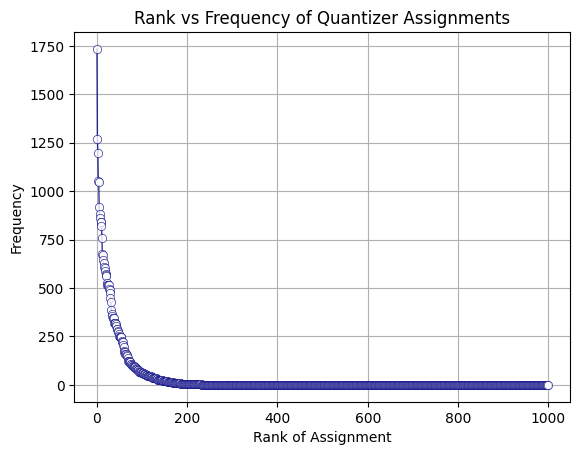

trained recall: 


0.9041496598639456

untrained recall: 


0.8763369963369964

In [101]:
k=100
nlist = 1000 
nprobe = 20
d = xb.shape[1]
compute_GT = True
SEED = 4

### init trained index
# ndex for coarse quantization
trained_quantizer = faiss.IndexFlatL2(d)  # flat index for coarse quantization
trained_index = faiss.IndexIVFFlat(trained_quantizer, d, nlist, faiss.METRIC_L2)
trained_index.cp.seed = SEED
trained_index.cp.niter= 25
trained_index.cp.nredo = 1
trained_index.verbose=True
# Train the IVF index
trained_index.train(xb)
trained_index.add(xb)

### init untrained index
untrained_quantizer = faiss.IndexFlatL2(d)  # flat index for coarse quantization
untrained_index = faiss.IndexIVFFlat(untrained_quantizer, d, nlist, faiss.METRIC_L2)
untrained_index.cp.seed = SEED #int(time.time())
untrained_index.cp.niter= 0
untrained_index.verbose=True
untrained_index.train(xb)
untrained_index.add(xb)

# Chose vectors from nearby clusters ( ~SKEWED DATASET HERE <<<<<< ? )
centr_first_cluster = trained_index.quantizer.reconstruct_n()[0]
n_nearest_cents = 2 # number of nearby clusters, if 1 then they are all from same cluster
nearest_cents = trained_index.quantizer.assign(centr_first_cluster.reshape(1, -1), n_nearest_cents)
nearest_cents.shape
# ids, codes = get_invlist(trained_index.invlists, 10)
ids, codes = get_points_in_invlists(trained_index, nearest_cents.ravel())
selected_vectors = codes.view("float32")

#### compute ground truth
if compute_GT:
    # selected_vectors.shape
    k= 100
    gt_index = faiss.IndexFlatL2(d)
    gt_index.add(xb)
    D, gt_selected_vectors = gt_index.search(selected_vectors, k)
    gt_selected_vectors.shape


## plot skew
visited_ids = get_centroid_ids_per_query(
    # index_ivf, 
    untrained_index, 
    selected_vectors, 
    nprobe=nprobe, 
    # nprobe=15, 
    plot_hist=True,
    sorted_order=True
    )

# recall target
print("trained recall: ")
trained_index.nprobe = nprobe
_, res_ids = trained_index.search(selected_vectors, k)
compute_recall(res_ids, gt_selected_vectors, k)

# recall target
print("untrained recall: ")
untrained_index.nprobe = nprobe
_, res_ids_untrained = untrained_index.search(selected_vectors, k)
compute_recall(res_ids_untrained, gt_selected_vectors, k)

In [36]:
selected_vectors.shape # queries
#  points in the 33% of centroids for nprobe of queries

(1576, 128)

In [19]:
pids_visited, p_visited = get_points_in_invlists(untrained_index, visited_cids)
pids_visited.shape

(330510,)

So we want to put more clusters in these 300k points ( and we want them to be from the queries )
Let's random choose 100 queries and turn them into centroids:

In [395]:
### init untrained index
untrained_quantizer = faiss.IndexFlatL2(d)  # flat index for coarse quantization
untrained_index = faiss.IndexIVFFlat(untrained_quantizer, d, nlist, faiss.METRIC_L2)
untrained_index.cp.seed = SEED
untrained_index.cp.niter= 0
untrained_index.verbose=True
untrained_index.train(xb)
untrained_index.add(xb)

### init untrained index
train1_quantizer = faiss.IndexFlatL2(d)  # flat index for coarse quantization
train1_index = faiss.IndexIVFFlat(train1_quantizer, d, nlist, faiss.METRIC_L2)
train1_index.cp.seed = SEED
train1_index.cp.niter= 1
train1_index.verbose=True
train1_index.train(xb)
train1_index.add(xb)

Training level-1 quantizer
Training level-1 quantizer on 1000000 vectors in 128D
Training IVF residual
IndexIVF: no residual training
IndexIVFFlat::add_core: added 1000000 / 1000000 vectors
Training level-1 quantizer
Training level-1 quantizer on 1000000 vectors in 128D
Training IVF residual
IndexIVF: no residual training
IndexIVFFlat::add_core: added 1000000 / 1000000 vectors


In [291]:
ivf_stats = faiss.cvar.indexIVF_stats

In [292]:
%%time
ivf_stats.reset()
untrained_index.nprobe = nprobe  # number of clusters to search
distances, indices_prev = untrained_index.search(selected_vectors, k)  # perform search
ivf_stats.ndis

CPU times: user 4.62 s, sys: 43.2 ms, total: 4.67 s
Wall time: 100 ms


51116971

In [293]:
# Compute Recall@k
recall_at_k = compute_recall(indices_prev, gt_selected_vectors, k)
print(f"Recall@{k}: {recall_at_k:.4f}")

Recall@100: 0.8763


In [245]:
# combined_centroids  = np.vstack((untrained_index.quantizer.reconstruct_n(), selected_vectors[:100,:])) # 100 random from selected vectors
combined_centroids  = np.vstack((untrained_index.quantizer.reconstruct_n(), selected_vectors[:500,:]))
print(f"{len(combined_centroids)=}")
cracked_quantizer = faiss.IndexFlatL2(d)
cracked_quantizer.add(combined_centroids)
cracked_index = faiss.IndexIVFFlat(cracked_quantizer, d, len(combined_centroids), faiss.METRIC_L2)
cracked_index.verbose = True
cracked_index.add(xb) # add points again with the new centroids form the cracking

len(combined_centroids)=1500
IndexIVFFlat::add_core: added 1000000 / 1000000 vectors


In [294]:
# combined_centroids  = np.vstack((untrained_index.quantizer.reconstruct_n(), selected_vectors[:100,:])) # 100 random from selected vectors

nlist_xq = 500
km_xq = faiss.Kmeans(d, nlist_xq, niter=10) 
km_xq.cp.niter= 10
km_xq.cp.nredo = 1
km_xq.cp.max_points_per_centroid = 256
km_xq.verbose = True

km_xq.verbose = True
km_xq.train(selected_vectors)

combined_centroids  = np.vstack((untrained_index.quantizer.reconstruct_n(), km_xq.centroids))
print(f"{len(combined_centroids)=}")

cracked_quantizer_trained = faiss.IndexFlatL2(d)
cracked_quantizer_trained.add(combined_centroids)
cracked_index_trained = faiss.IndexIVFFlat(cracked_quantizer_trained, d, len(combined_centroids), faiss.METRIC_L2)
cracked_index_trained.verbose = True
cracked_index_trained.add(xb) # add points again with the new centroids form the cracking

WARNING clustering 1911 points to 500 centroids: please provide at least 19500 training points


44287848.0

len(combined_centroids)=1500
IndexIVFFlat::add_core: added 1000000 / 1000000 vectors


compare ndis from them:

In [295]:
faiss.omp_set_num_threads(1)

In [296]:
%%time
ivf_stats.reset()
untrained_index.nprobe = nprobe  # number of clusters to search
distances, indices_prev = untrained_index.search(selected_vectors, k)  # perform search
ivf_stats.ndis

CPU times: user 1.08 s, sys: 103 μs, total: 1.08 s
Wall time: 1.08 s


51116971

In [297]:
%%time
ivf_stats.reset()
trained_index.nprobe = nprobe  # number of clusters to search
distances, indices_prev_trained = trained_index.search(selected_vectors, k)  # perform search
ivf_stats.ndis

CPU times: user 644 ms, sys: 4.21 ms, total: 648 ms
Wall time: 646 ms


35099260

In [ ]:
# Compute Recall@k
recall_at_k = compute_recall(indices_prev_trained, gt_selected_vectors, k)
print(f"Recall@{k}: {recall_at_k:.4f}")

Recall@100: 0.8001


In [41]:
%%time
ivf_stats.reset()

cracked_index.nprobe = 80  # number of clusters to search
distances, indices_cracked = cracked_index.search(selected_vectors, k)  # perform search
# # Compute Recall@k
# recall_at_k = compute_recall(indices, gt, k)
# print(f"Recall@{k}: {recall_at_k:.4f}")
ivf_stats.ndis


NameError: name 'cracked_index' is not defined

In [261]:
# Compute Recall@k
recall_at_k = compute_recall(indices_cracked, gt_selected_vectors, k)
print(f"Recall@{k}: {recall_at_k:.4f}")


Recall@100: 0.8003


In [25]:
ivf_stats.reset()

cracked_index_trained.nprobe = nprobe  # number of clusters to search
distances, indx_cracked_trained = cracked_index_trained.search(selected_vectors, k)  # perform search
# # Compute Recall@k
# recall_at_k = compute_recall(indices, gt, k)
# print(f"Recall@{k}: {recall_at_k:.4f}")

NameError: name 'cracked_index_trained' is not defined

In [41]:
# Compute Recall@k
recall_at_k = compute_recall(indx_cracked_trained, gt_selected_vectors, k)
print(f"Recall@{k}: {recall_at_k:.4f}")

Recall@100: 0.8077


Let's "forget" some other centroids and part of the have most of the 1k be at the hot region:

(333,)

(800, 128)

#### Run here

In [408]:
centrs = untrained_index.quantizer.reconstruct_n()

visited_cids.shape # the ones we visit
# not_visited_ids = # the ones we did not visite
# trimmed_cents = centrs[visited_cids]

keep_size = 800  # Desired size of trimmed centroids

# Step 1: Get indices of centroids not in visited_cids
all_indices = np.arange(nlist)
remaining_indices = np.setdiff1d(all_indices, visited_cids)

# Step 2: Calculate number of additional centroids needed
additional_needed = keep_size - len(visited_cids)

# Step 3: Randomly sample additional centroids without replacement
if additional_needed > 0:
    additional_indices = np.random.choice(remaining_indices, size=additional_needed, replace=False)
else:
    additional_indices = np.array([])  # No additional centroids needed

# Step 4: Combine visited_cids and additional_indices
final_indices = np.concatenate([visited_cids, additional_indices])
trimmed_cents = centrs[final_indices]

# Result
trimmed_cents.shape

(333,)

(800, 128)

In [409]:
# combined_centroids  = np.vstack((untrained_index.quantizer.reconstruct_n(), selected_vectors[:100,:])) # 100 random from selected vectors
rndm = selected_vectors[np.random.choice(selected_vectors.shape[0], size=nlist-trimmed_cents.shape[0], replace=False), :]
combined_centroids  = np.vstack((trimmed_cents, rndm))

# first_x = selected_vectors[:nlist-trimmed_cents.shape[0],:]
# combined_centroids  = np.vstack((trimmed_cents, first_x))

# combined_centroids  = np.vstack((trimmed_cents, km_xq.centroids))
print(f"{len(combined_centroids)=}")

cracked_quantizer_2 = faiss.IndexFlatL2(d)
cracked_quantizer_2.add(combined_centroids)
cracked_index_2 = faiss.IndexIVFFlat(cracked_quantizer_2, d, len(combined_centroids), faiss.METRIC_L2)
cracked_index_2.verbose = True
cracked_index_2.add(xb) # add points again with the new centroids form the cracking

len(combined_centroids)=1000
IndexIVFFlat::add_core: added 1000000 / 1000000 vectors


In [376]:
k=10
# %%time
ivf_stats.reset()

# eg. used to be 333 cents in this region (visited) now there are +400 = 733 thus nprobe new = 20*733/433 ~=44 (too low)
cracked_index_2.nprobe = 25  # number of clusters to search
distances, idx2 = cracked_index_2.search(selected_vectors, k)  # perform search
# distances, idx2 = cracked_index_2.search(selected_vectors[nlist-trimmed_cents.shape[0]:, :], k)  # perform search only on future queries after crack
cracked_ndis = ivf_stats.ndis
# # Compute Recall@k
# recall_at_k = compute_recall(indices, gt, k)
# print(f"Recall@{k}: {recall_at_k:.4f}")

In [397]:
# ## plot skew
# vvids = get_centroid_ids_per_query(
#     # index_ivf, 
#     untrained_index, 
#     selected_vectors, 
#     # selected_vectors[0:1,:], 
#     nprobe=20, 
#     # nprobe=15, 
#     plot_hist=True,
#     sorted_order=True
# )
# pids_v, p_v = get_points_in_invlists(untrained_index, vvids)
# pids_v.shape


# ## plot skew
# vvids = get_centroid_ids_per_query(
#     # index_ivf, 
#     trained_index, 
#     selected_vectors, 
#     # selected_vectors[0:1,:], 
#     nprobe=20, 
#     # nprobe=15, 
#     plot_hist=True,
#     sorted_order=True
# )

# pids_v, p_v = get_points_in_invlists(trained_index, vvids)
# pids_v.shape

# vvids = get_centroid_ids_per_query(
#     # index_ivf, 
#     cracked_index_2, 
#     selected_vectors, 
#     # selected_vectors[0:1,:], 
#     nprobe=20, 
#     # nprobe=15, 
#     plot_hist=True,
#     sorted_order=True
#     )

# pids_v, p_v = get_points_in_invlists(cracked_index_2, vvids)
# pids_v.shape

In [373]:
print()
print("cracked")
# Compute Recall@k
print(f"{cracked_ndis=}")
recall_at_k = compute_recall(idx2, gt_selected_vectors, k)
# recall_at_k = compute_recall(idx2, gt_selected_vectors[0:1,:], k)
# recall_at_k = compute_recall(idx2, gt_selected_vectors[nlist-trimmed_cents.shape[0]:, :], k)
print(f"Recall@{k}: {recall_at_k:.4f}")



cracked
cracked_ndis=7300
Recall@10: 0.9000


In [425]:
nprobe = 10
nprobe_cracked  = 25

print()
print("untrained")
ivf_stats.reset()
untrained_index.nprobe = nprobe  # number of clusters to search
distances, indices_prev = untrained_index.search(selected_vectors, k)  # perform search
# distances, indices_prev = untrained_index.search(selected_vectors[nlist-trimmed_cents.shape[0]:, :], k)  # perform search
untrained_nds = ivf_stats.ndis
print(f"untraied ndis = {ivf_stats.ndis}")
# Compute Recall@k
recall_at_k = compute_recall(indices_prev, gt_selected_vectors, k)
# recall_at_k = compute_recall(indices_prev, gt_selected_vectors[nlist-trimmed_cents.shape[0]:, :], k)
print(f"Recall@{k}: {recall_at_k:.4f}")
print()


print("trained niter=1")
ivf_stats.reset()
train1_index.nprobe = nprobe  # number of clusters to search
distances, indices_prev_trained_1 = train1_index.search(selected_vectors, k)  # perform search
# distances, indices_prev = trained_index.search(selected_vectors[nlist-trimmed_cents.shape[0]:, :], k)  # perform search
once_trained_ndis = ivf_stats.ndis
print(f"trained ndis = {ivf_stats.ndis}")
recall_at_k = compute_recall(indices_prev_trained_1, gt_selected_vectors, k)
# recall_at_k = compute_recall(indices_prev, gt_selected_vectors[nlist-trimmed_cents.shape[0]:, :], k)
print(f"Recall@{k}: {recall_at_k:.4f}")


print("trained")
ivf_stats.reset()
trained_index.nprobe = nprobe  # number of clusters to search
distances, indices_prev_trained = trained_index.search(selected_vectors, k)  # perform search
# distances, indices_prev = trained_index.search(selected_vectors[nlist-trimmed_cents.shape[0]:, :], k)  # perform search
trained_ndis = ivf_stats.ndis
print(f"trained ndis = {ivf_stats.ndis}")
# Compute Recall@k
recall_at_k = compute_recall(indices_prev_trained, gt_selected_vectors, k)
# recall_at_k = compute_recall(indices_prev, gt_selected_vectors[nlist-trimmed_cents.shape[0]:, :], k)
print(f"Recall@{k}: {recall_at_k:.4f}")


print()
print("cracked")
ivf_stats.reset()
cracked_index_2.nprobe = nprobe_cracked  # number of clusters to search
distances, idx2 = cracked_index_2.search(selected_vectors, k)  # perform search
cracked_ndis = ivf_stats.ndis
# Compute Recall@k
print(f"{cracked_ndis=}")
recall_at_k = compute_recall(idx2, gt_selected_vectors, k)
# recall_at_k = compute_recall(idx2, gt_selected_vectors[nlist-trimmed_cents.shape[0]:, :], k)
print(f"Recall@{k}: {recall_at_k:.4f}")


untrained
untraied ndis = 26355202
Recall@10: 0.8503

trained niter=1
trained ndis = 19196588
Recall@10: 0.8687
trained
trained ndis = 17388843
Recall@10: 0.8858

cracked
cracked_ndis=16066956
Recall@10: 0.8794


In [426]:
print("vs trained full")
print(cracked_ndis)
print(cracked_ndis - trained_ndis) # trained
print((cracked_ndis - trained_ndis)/(trained_ndis) * 100, "%")
print("vs trained once")
print(cracked_ndis - once_trained_ndis) # untrained
print((cracked_ndis - once_trained_ndis)/(once_trained_ndis) * 100, "%")
print("vs trained full")
print(cracked_ndis - untrained_nds) # untrained
print((cracked_ndis - untrained_nds)/(untrained_nds) * 100 ,"%")

vs trained full
16066956
-1321887
-7.601926131600591 %
vs trained once
-3129632
-16.303063856972916 %
vs trained full
-10288246
-39.03687021636184 %


In [313]:
# # Compute Recall@k
# # recall_at_k = compute_recall(idx2, gt_selected_vectors[nlist-trimmed_cents.shape[0]:, :], k)
# print(f"Recall@{k}: {recall_at_k:.4f}")

What I learned:
- you can crack space, but you need to increase nprobe, by how much I do not know but I guess Jason's paper gives the answer
- what the cost for cracking is is uknown but indeed you can crack enough so that untrained index performance ~= trained index performance for a query workload
- if query workload shifts you need to crack again and move points again

untraied ndis = 41966455
Recall@100: 0.7229
trained ndis = 30204789
Recall@100: 0.8001
CPU times: user 1.52 s, sys: 17 μs, total: 1.52 s
Wall time: 1.52 s


In [ ]:
# combined_centroids  = np.vstack((untrained_index.quantizer.reconstruct_n(), selected_vectors[:100,:])) # 100 random from selected vectors

combined_centroids  = np.vstack((untrained_index.quantizer.reconstruct_n(), km_xq.centroids))
print(f"{len(combined_centroids)=}")

cracked_quantizer_trained = faiss.IndexFlatL2(d)
cracked_quantizer_trained.add(combined_centroids)
cracked_index_trained = faiss.IndexIVFFlat(cracked_quantizer_trained, d, len(combined_centroids), faiss.METRIC_L2)
cracked_index_trained.verbose = True
cracked_index_trained.add(xb) # add points again with the new centroids form the cracking

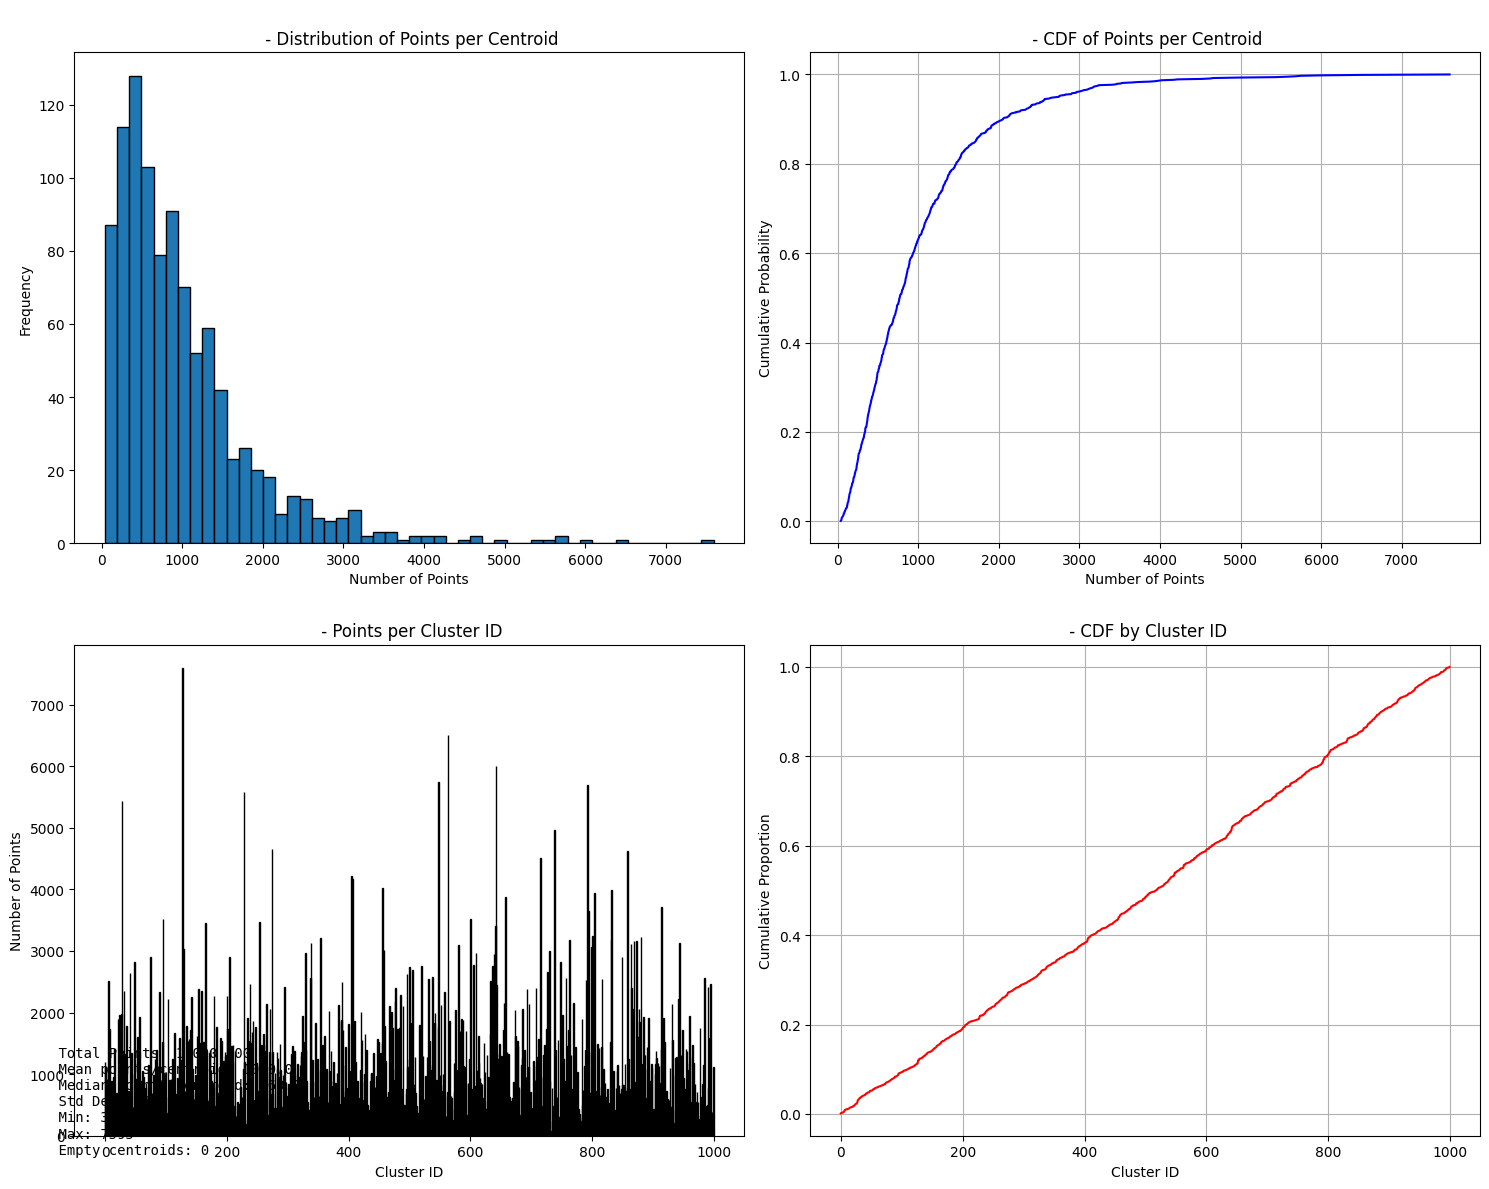

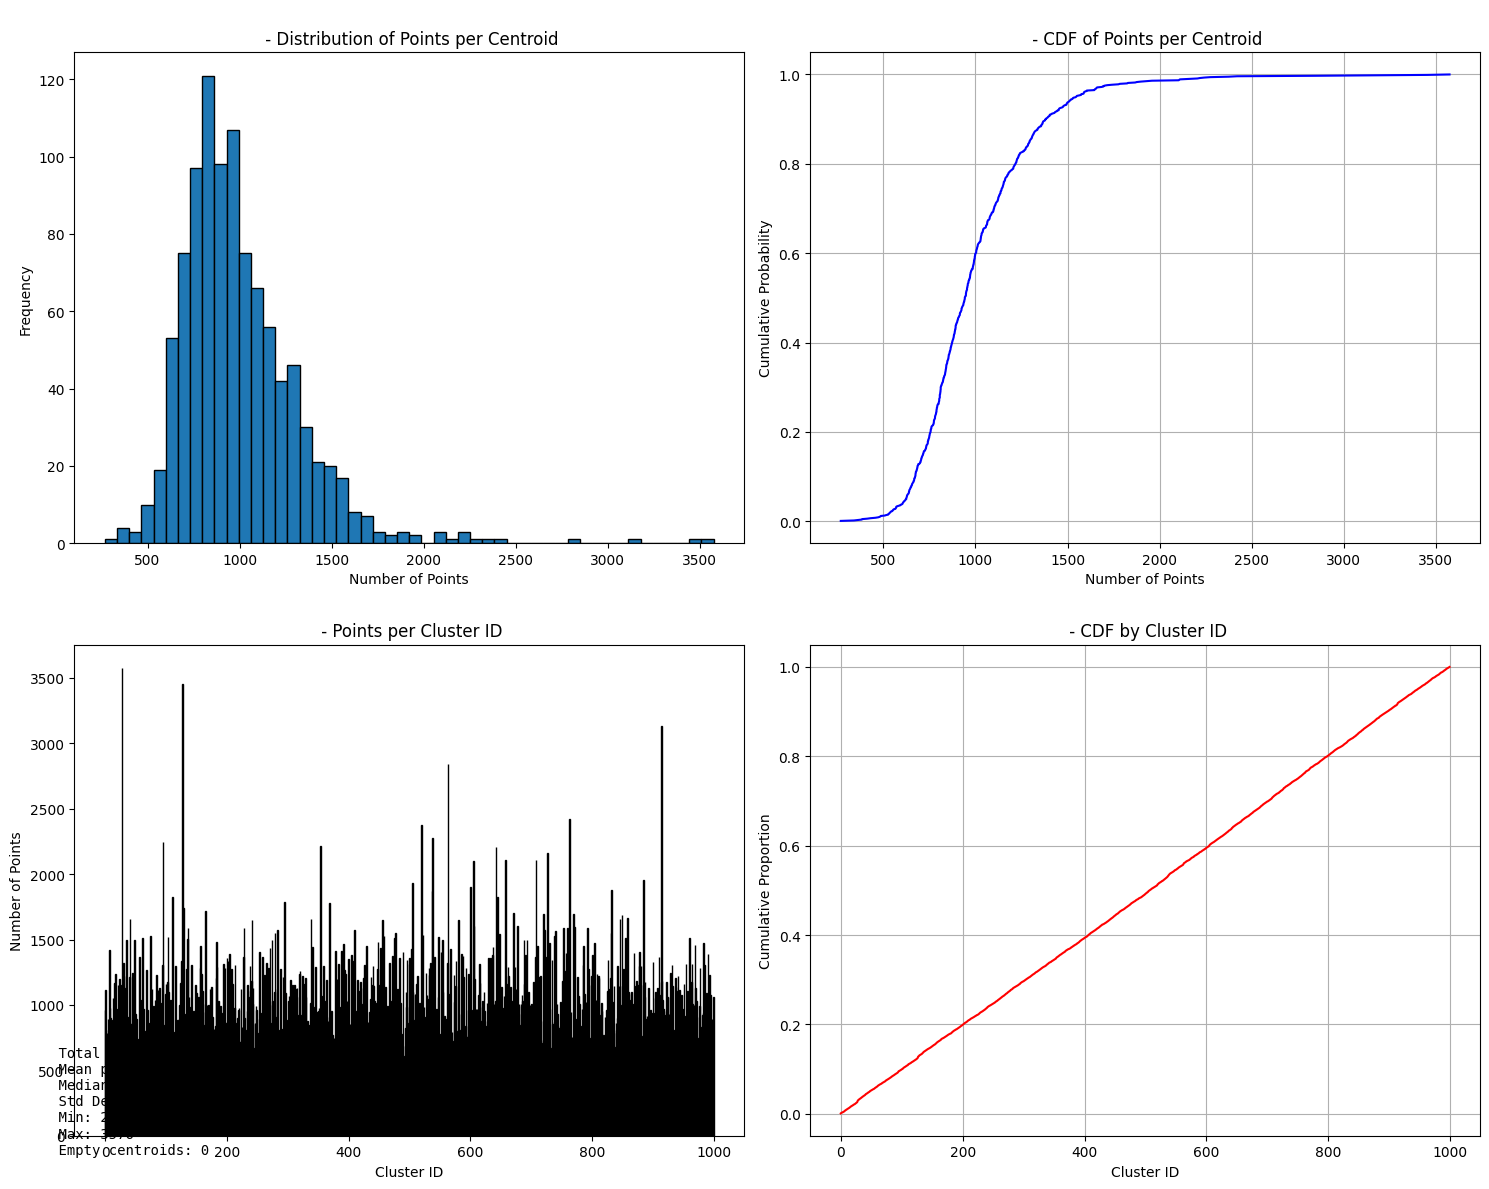

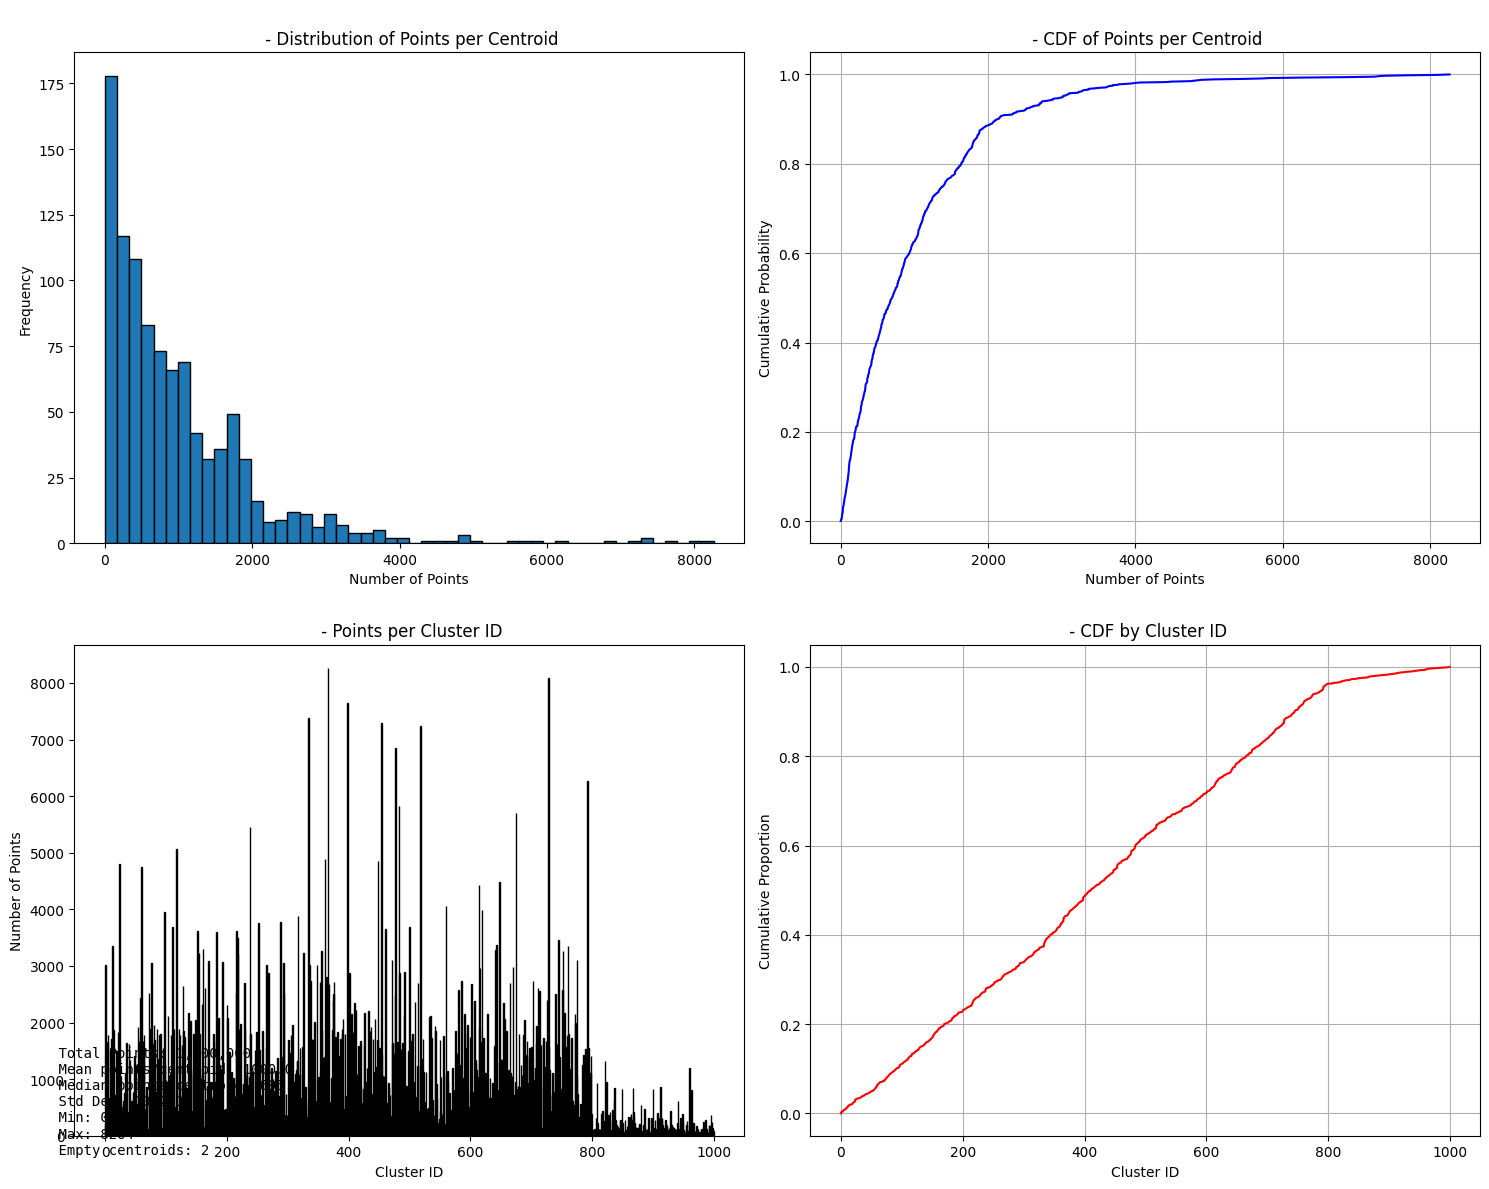

In [430]:
_ = analyze_cluster_distribution(untrained_index)
_ = analyze_cluster_distribution(trained_index)
_ = analyze_cluster_distribution(cracked_index_2)

In [170]:
def analyze_cluster_distribution(index, NAME=""):
    """
    Efficiently analyzes the distribution of points across centroids in a FAISS index
    using direct SWIG access to internal assignments.
    
    Args:
        index: Trained FAISS index (IVF-based)
        NAME: String to prefix plot titles
    Returns:
        dict: Mapping of centroid_id to number of points
    """
    # Get the inverted lists object
    invlists = faiss.extract_index_ivf(index).invlists
    
    # Initialize counts dictionary
    centroid_distribution = {}
    
    # Iterate through all lists to get counts
    for i in range(invlists.nlist):
        centroid_distribution[i] = invlists.list_size(i)
    
    # Create figure with four subplots
    fig = plt.figure(figsize=(15, 12))
    gs = plt.GridSpec(2, 2, figure=fig)
    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[0, 1])
    ax3 = fig.add_subplot(gs[1, 0])
    ax4 = fig.add_subplot(gs[1, 1])
    
    # Histogram of counts
    counts = list(centroid_distribution.values())
    ax1.hist(counts, bins=50, edgecolor='black')
    ax1.set_title(f'{NAME}\n - Distribution of Points per Centroid')
    ax1.set_xlabel('Number of Points')
    ax1.set_ylabel('Frequency')
    
    # CDF of counts
    counts_sorted = sorted(counts)
    cumulative = np.arange(1, len(counts_sorted) + 1) / len(counts_sorted)
    ax2.plot(counts_sorted, cumulative, 'b-')
    ax2.set_title(f'{NAME}\n - CDF of Points per Centroid')
    ax2.set_xlabel('Number of Points')
    ax2.set_ylabel('Cumulative Probability')
    ax2.grid(True)
    
    # Histogram by cluster ID
    cluster_ids = list(centroid_distribution.keys())
    cluster_sizes = list(centroid_distribution.values())
    ax3.bar(cluster_ids, cluster_sizes, width=1.0, edgecolor='black')
    ax3.set_title(f'{NAME}\n - Points per Cluster ID')
    ax3.set_xlabel('Cluster ID')
    ax3.set_ylabel('Number of Points')
    
    # CDF by cluster ID
    sorted_by_id = sorted(centroid_distribution.items())
    cluster_ids_sorted = [x[0] for x in sorted_by_id]
    counts_by_id = [x[1] for x in sorted_by_id]
    cumulative_by_id = np.cumsum(counts_by_id) / sum(counts_by_id)
    ax4.plot(cluster_ids_sorted, cumulative_by_id, 'r-')
    ax4.set_title(f'{NAME}\n - CDF by Cluster ID')
    ax4.set_xlabel('Cluster ID')
    ax4.set_ylabel('Cumulative Proportion')
    ax4.grid(True)
    
    # Add some statistics as text
    stats_text = f"""
    Total Points: {sum(counts):,}
    Mean points/centroid: {np.mean(counts):.1f}
    Median points/centroid: {np.median(counts):.1f}
    Std Dev: {np.std(counts):.1f}
    Min: {min(counts)}
    Max: {max(counts)}
    Empty centroids: {sum(1 for x in counts if x == 0)}
    """
    fig.text(0.02, 0.02, stats_text, fontsize=10, family='monospace')
    
    plt.tight_layout()
    plt.show()
    
    return centroid_distribution

# Query Skewness

In [ ]:
k=100

# FAISS index creation
nlist = 1000  # number of clusters for IVF
quantizer = faiss.IndexFlatL2(d)  # flat index for coarse quantization
index_ivf_small = faiss.IndexIVFFlat(quantizer, d, nlist, faiss.METRIC_L2)

# Train the IVF index
index_ivf_small.train(xb)
index_ivf_small.add(xb)

NameError: name 'xb' is not defined

In [ ]:
from collections import Counter
import matplotlib.pyplot as plt

In [ ]:
import numpy as np

def generate_perturbed_vectors(centr_0, epsilon, size):
    """
    Generate a numpy array of perturbed vectors around the original vector.

    :param centr_0: The original vector (1D numpy array).
    :param epsilon: The perturbation magnitude.
    :param size: The number of perturbed vectors to generate (including the original).
    :return: A numpy array of perturbed vectors with shape (size, dimensions).
    """
    # Get the dimensions of the original vector
    dimensions = centr_0.shape[0]
    
    # Initialize an array to hold the perturbed vectors
    perturbed_vectors = np.zeros((size, dimensions))
    
    # The first vector is the original vector
    perturbed_vectors[0] = centr_0
    
    # Generate the remaining perturbed vectors
    for i in range(1, size):
        # Generate a small Gaussian perturbation
        perturbation = np.random.normal(loc=0, scale=epsilon, size=centr_0.shape)
        
        # Apply the perturbation to the original vector
        perturbed_vectors[i] = centr_0 + perturbation
        
    return perturbed_vectors

In [198]:
centr_0 = quantizer.reconstruct_n()[0]

epsilon = 50  # Perturbation magnitude
size = 10000  # Number of perturbed vectors (including the original)

perturbed_vectors = generate_perturbed_vectors(centr_0, epsilon, size)
perturbed_vectors.shape

(10000, 128)

In [199]:
from vasili_helpers import *

In [343]:
k=100

# FAISS index creation
nlist = 1000  # number of clusters for IVF
quantizer = faiss.IndexFlatL2(d)  # flat index for coarse quantization
other_index = faiss.IndexIVFFlat(quantizer, d, nlist, faiss.METRIC_L2)
other_index.cp.seed = int(time.time())

# Train the IVF index
other_index.train(xb)
other_index.add(xb)

In [367]:
selected_vectors, _ = increase_queries_zipfian(selected_vectors, None, factor=5)
selected_vectors.shape

(56600, 128)

In [ ]:
# selected_vectors = perturbed_vectors

ids, codes = get_invlist(index_ivf_small.invlists, 10)
codes.view("float32").shape
selected_vectors = codes.view("float32")

ids, codes = get_invlist(other_index.invlists, 0)
codes.view("float32").shape
selected_vectors = codes.view("float32")

# all points from one cluster and nearby cluster:
centr_first_cluster = other_index.quantizer.reconstruct_n()[0]
n_nearest_cents = 1
nearest_cents = other_index.quantizer.assign(centr_first_cluster.reshape(1,-1), n_nearest_cents)
# ids, codes = get_invlist(other_index.invlists, 10)
ids, codes = get_points_in_invlists(other_index, nearest_cents.ravel())
codes.shape
selected_vectors = codes.view("float32")
selected_vectors.shape
# selected_vectors, _ = increase_queries_zipfian(selected_vectors, None, factor=100)
# selected_vectors.shape


(999, 128)

(1132, 128)

(1132, 128)

(1132, 128)

In [385]:
selected_vectors.shape
k= 100
gt_index = faiss.IndexFlatL2(d)
gt_index.add(xb)
D, gt_selected_vectors = gt_index.search(selected_vectors, k)

gt_selected_vectors.shape

(1132, 128)

(1132, 100)

In [395]:
k=100

# FAISS index creation
nlist = 1000  # number of clusters for IVF
quantizer = faiss.IndexFlatL2(d)  # flat index for coarse quantization
untrained_index = faiss.IndexIVFFlat(quantizer, d, nlist, faiss.METRIC_L2)
untrained_index.cp.seed = int(time.time())
untrained_index.cp.niter= 0
untrained_index.verbose=True

# Train the IVF index
untrained_index.train(xb)
untrained_index.add(xb)

Training level-1 quantizer
Training level-1 quantizer on 1000000 vectors in 128D
Training IVF residual
IndexIVF: no residual training
IndexIVFFlat::add_core: added 1000000 / 1000000 vectors


In [431]:
k=100
nlist = 1000 
nprobe = 20
d=xb.shape[1]
compute_GT = True

### init trained index
# ndex for coarse quantization
trained_quantizer = faiss.IndexFlatL2(d)  # flat index for coarse quantization
trained_index = faiss.IndexIVFFlat(trained_quantizer, d, nlist, faiss.METRIC_L2)
trained_index.cp.seed = int(time.time())
trained_index.cp.niter= 10
trained_index.cp.nredo = 10
trained_index.verbose=True
# Train the IVF index
trained_index.train(xb)
trained_index.add(xb)

### init untrained index
untrained_quantizer = faiss.IndexFlatL2(d)  # flat index for coarse quantization
untrained_index = faiss.IndexIVFFlat(untrained_quantizer, d, nlist, faiss.METRIC_L2)
untrained_index.cp.seed = int(time.time())
untrained_index.cp.niter= 0
untrained_index.verbose=True
untrained_index.train(xb)
untrained_index.add(xb)

# Chose vectors from nearby clusters
centr_first_cluster = trained_index.quantizer.reconstruct_n()[0]
n_nearest_cents = 1 # number of nearby clusters, if 1 then they are all from same cluster
nearest_cents = trained_index.quantizer.assign(centr_first_cluster.reshape(1, -1), n_nearest_cents)
# ids, codes = get_invlist(trained_index.invlists, 10)
ids, codes = get_points_in_invlists(trained_index, nearest_cents.ravel())
selected_vectors = codes.view("float32")

#### compute ground truth
if compute_GT:
    # selected_vectors.shape
    k= 100
    gt_index = faiss.IndexFlatL2(d)
    gt_index.add(xb)
    D, gt_selected_vectors = gt_index.search(selected_vectors, k)
    gt_selected_vectors.shape

#### get recall
selected_vectors
trained_index.nprobe = nprobe
D, I_sel_vec = trained_index.search(selected_vectors, k)

print("trained recall")
compute_recall(I_sel_vec, gt_selected_vectors, k)

untrained_index.nprobe = nprobe
D, I_sel_vec = untrained_index.search(selected_vectors, k)
print("un-trained recall")
compute_recall(I_sel_vec, gt_selected_vectors, k)

Training level-1 quantizer
Training level-1 quantizer on 1000000 vectors in 128D
Training IVF residual
IndexIVF: no residual training
IndexIVFFlat::add_core: added 1000000 / 1000000 vectors
Training level-1 quantizer
Training level-1 quantizer on 1000000 vectors in 128D
Training IVF residual
IndexIVF: no residual training
IndexIVFFlat::add_core: added 1000000 / 1000000 vectors


(578, 100)

array([[21., 12.,  3., ...,  0.,  1., 23.],
       [42., 10.,  1., ...,  9., 98., 25.],
       [41., 18.,  3., ..., 13., 32., 12.],
       ...,
       [28.,  7., 27., ...,  0.,  1., 42.],
       [99.,  9., 11., ...,  0.,  0.,  0.],
       [62., 11., 11., ...,  6.,  2., 42.]], dtype=float32)

trained recall


0.9071453287197232

un-trained recall


0.8205882352941176

<Figure size 800x600 with 0 Axes>

Text(0.5, 0, 'Rank of Assignment')

Text(0, 0.5, 'Frequency (log scale)')

Text(0.5, 1.0, 'Zipfian Distribution of Quantizer Assignments (Log-Log Plot)')

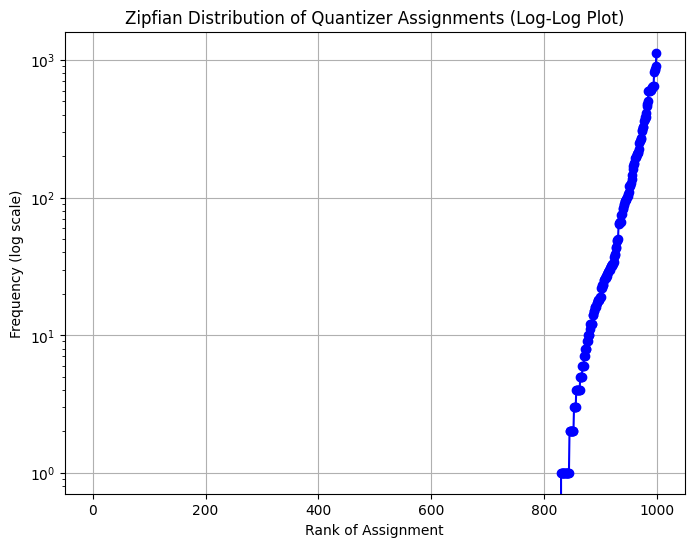

- Total number of unique centroids visited: 170
- % of total centroids: 17.0 %


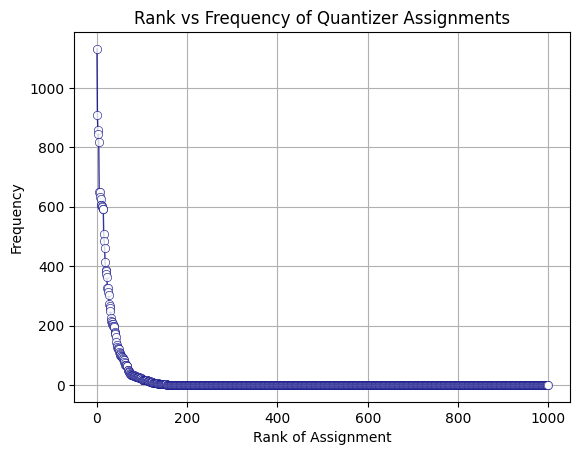

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

# Example of quantizer.assign(perturbed_vectors, nprobe) usage
nprobe=20
assignment_counts = Counter(index_ivf_small.quantizer.assiagn(selected_vectors, nprobe).ravel())

# Ensure all centroids are included, even if some are missing
n_centroids = 1000
for i in range(n_centroids):
    if i not in assignment_counts:
        assignment_counts[i] = 0

# Sort assignments by frequency (descending order)
sorted_assignments = sorted(assignment_counts.items(), key=lambda x: x[1], reverse=False)

# Extract the sorted assignments and counts
unique_assignments = [item[0] for item in sorted_assignments]
counts = [item[1] for item in sorted_assignments]

# Plotting the frequencies to visualize Zipfian distribution
plt.figure(figsize=(8, 6))
plt.plot(counts, marker='o', linestyle='-', color='b')

# Log-log scale
# plt.xscale('log')
plt.yscale('log')

plt.xlabel('Rank of Assignment')
plt.ylabel('Frequency (log scale)')
plt.title('Zipfian Distribution of Quantizer Assignments (Log-Log Plot)')
plt.grid(True)
plt.show()

get_centroid_ids_per_query(
    # index_ivf, 
    index_ivf_small, 
    selected_vectors, 
    nprobe=nprobe, 
    # nprobe=15, 
    plot_hist=True,
    sorted_order=True
    )

In [378]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

def get_centroid_ids_per_query(index, queries, nprobe=10, plot_hist=False, sorted_order=False):
    # Perform the quantization (search over the queries)
    _, cids = index.quantizer.search(queries, nprobe)
    
    # Initialize counts for all centroids (0 to index.nlist-1) as 0
    n_centroids = index.nlist
    counts = np.zeros(n_centroids, dtype=int)

    # Update counts based on the cids
    unique_values, cid_counts = np.unique(cids.flatten(), return_counts=True)
    counts[unique_values] = cid_counts  # Set count for visited centroids

    num_unique = len(unique_values)
    print(f"- Total number of unique centroids visited: {num_unique}")
    print(f"- % of total centroids: {100 * round(num_unique / n_centroids, 2)} %")
    
    if plot_hist:
        # Sort by frequency if sorted_order=True
        if sorted_order:
            # Sort centroids by frequency (highest frequency first)
            sorted_indices = np.argsort(counts)[::-1]  # Get indices sorted by counts in descending order
            sorted_counts = counts[sorted_indices]
        else:
            sorted_counts = counts

        # Create ranks based on sorted order
        ranks = np.argsort(counts)[::-1]  # Rank assignments based on frequency

        # Plot rank vs frequency
        # plt.plot(sorted_counts, marker='o', linestyle='-', color='b')
        # plt.plot(sorted_counts, marker='s', linestyle='--', color='b', linewidth=2, markeredgewidth=0.01)
        plt.plot(sorted_counts, marker='o', linestyle='-', color='navy', linewidth=1, alpha=0.8, markerfacecolor='white', markeredgecolor='navy', markeredgewidth=.5)
        # plt.plot(sorted_counts, linestyle='-', color='black', linewidth=1) # minimalist
        # plt.plot(sorted_counts, marker='D', linestyle='-.', color='orange', linewidth=2)


        
        plt.xlabel('Rank of Assignment')
        plt.ylabel('Frequency')

        # plt.yscale('log')
        plt.title('Rank vs Frequency of Quantizer Assignments')
        plt.grid(True)
        plt.show()


In [222]:

def get_centroid_ids_per_query(index, queries, nprobe=10, plot_hist=False):
    _, cids = index.quantizer.search(queries, nprobe)
    num_unique = len(np.unique(cids))
    print(f"- Total number of unique centroids visited: {num_unique}")
    print(f"- % of total centroids: {100*round(num_unique/index.nlist,2)} %")
    if plot_hist:
        unique_values, counts = np.unique(cids.flatten(), return_counts=True)
        plt.bar(unique_values, counts, width=5, color='skyblue', edgecolor='black')
        plt.xlabel('Centroid IDs')
        plt.ylabel('Frequency')
        plt.title('Histogram of Centroid Frequencies across queries')
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.show()
